In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from kaggle_hm.utils import init_nb
import matplotlib.patches as mpatches
import numpy as np

init_nb()

In [5]:
customers = pd.read_parquet('../data/clean/customers.parquet')

sample = customers.sample(n=1000, random_state=1)
items = pd.read_parquet('../data/clean/articles.parquet')
t = pd.read_parquet('../data/clean/transactions.parquet')
t = t[t['customer_id'].isin(sample['customer_id'])]
t_ext = t.merge(items[['article_id', 'prod_name', 'product_group_name', 'perceived_colour_master_name', 'index_name', 'product_type_name']])
t_ext['dow'] = t_ext['t_dat'].dt.dayofweek.map({0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"})
season_map = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'}
t_ext['season'] = t_ext['t_dat'].dt.month.map(season_map)

In [291]:
customer = sample.iloc[3]['customer_id']

print(sample.iloc[3])

t_ext[t_ext['customer_id'] == customer][['t_dat', 'dow', 'price', 'article_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name', 'perceived_colour_master_name', 'sales_channel_id']].sort_values('t_dat')

customer_id               bb455bc38400bd6902f9bea828df555a3d55818fcb144b...
FN                                                                    1.000
Active                                                                1.000
club_member_status                                                   ACTIVE
fashion_news_frequency                                            Regularly
age                                                                  54.000
postal_code               1d98a184bc258bf41ea61b66cdcc46bc5c05c2d982c38e...
Name: 1003611, dtype: object


,t_dat,dow,price,article_id,prod_name,product_type_name,product_group_name,index_name,perceived_colour_master_name,sales_channel_id
3290,2020-05-18,Mon,0.017,688558001,Brittany LS,Top,Garment Upper body,Divided,Black,2
3291,2020-05-18,Mon,0.017,688558001,Brittany LS,Top,Garment Upper body,Divided,Black,2
4261,2020-05-18,Mon,0.034,706016002,Jade HW Skinny Denim TRS,Trousers,Garment Lower body,Divided,Blue,2
19090,2020-05-18,Mon,0.012,800691008,Claudine rib t-shirt,T-shirt,Garment Upper body,Ladieswear,Black,2
20659,2020-05-18,Mon,0.025,806225009,All That Jazz Push Up Bra,Bikini top,Swimwear,Lingeries/Tights,White,2
22158,2020-08-12,Wed,0.042,852585002,Tinos mesh tights,Leggings/Tights,Garment Lower body,Sport,Black,2
22165,2020-08-12,Wed,0.042,730683050,HAVANA HW tights,Unknown,Unknown,Sport,Black,2


Let's explore basic characteristics of sales

In [6]:
t_ext.shape

(23715, 11)

In [112]:
t_ext['product_type_name'].value_counts(normalize=True) * 100

Trousers                   13.591
Dress                       9.534
Sweater                     9.382
T-shirt                     6.882
Top                         5.246
Bra                         4.335
Blouse                      4.305
Vest top                    4.069
Shorts                      3.550
Underwear bottom            3.394
Swimwear bottom             3.361
Bikini top                  3.310
Shirt                       2.800
Skirt                       2.783
Leggings/Tights             2.319
Jacket                      1.923
Socks                       1.876
Hoodie                      1.720
Blazer                      1.421
Cardigan                    1.130
Swimsuit                    0.717
Boots                       0.683
Earring                     0.666
Belt                        0.628
Jumpsuit/Playsuit           0.616
Scarf                       0.595
Underwear Tights            0.595
Bag                         0.590
Pyjama set                  0.561
Sneakers      

In [7]:
t_ext['product_type_name'].value_counts(normalize=True)[:20].sum()

0.8693232131562303

To keep charts readable let's limit data to top-20 products, they account for 87% of items sold.

In [8]:
top_prods = set(t_ext['product_type_name'].value_counts()[:20].index)
top_t = t_ext[t_ext['product_type_name'].isin(top_prods)]

In [259]:
items['product_type_name'].value_counts(normalize=True)[:20]

Trousers           0.106
Dress              0.098
Sweater            0.088
T-shirt            0.075
Top                0.039
Blouse             0.038
Jacket             0.037
Shorts             0.037
Shirt              0.032
Vest top           0.028
Underwear bottom   0.026
Skirt              0.026
Hoodie             0.022
Bra                0.021
Socks              0.018
Leggings/Tights    0.018
Sneakers           0.015
Cardigan           0.015
Hat/beanie         0.013
Garment Set        0.013
Name: product_type_name, dtype: float64

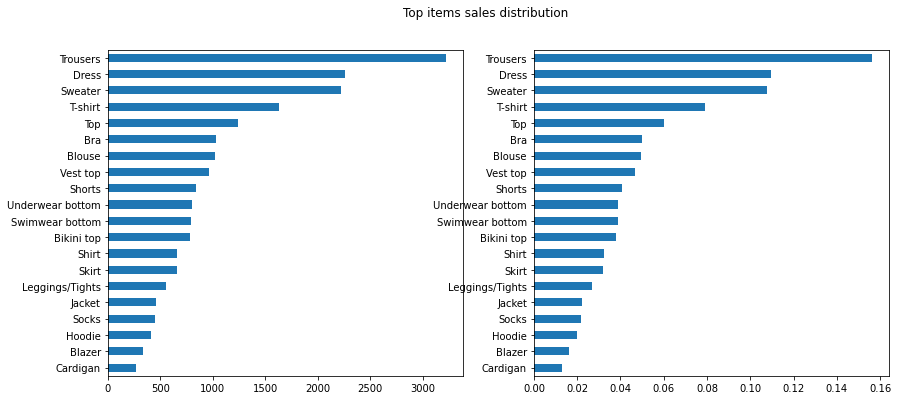

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

top_t['product_type_name'].value_counts().sort_values().plot.barh(ax=ax[0])
top_t['product_type_name'].value_counts(normalize=True).sort_values().plot.barh(ax=ax[1])

plt.suptitle('Top items sales distribution');

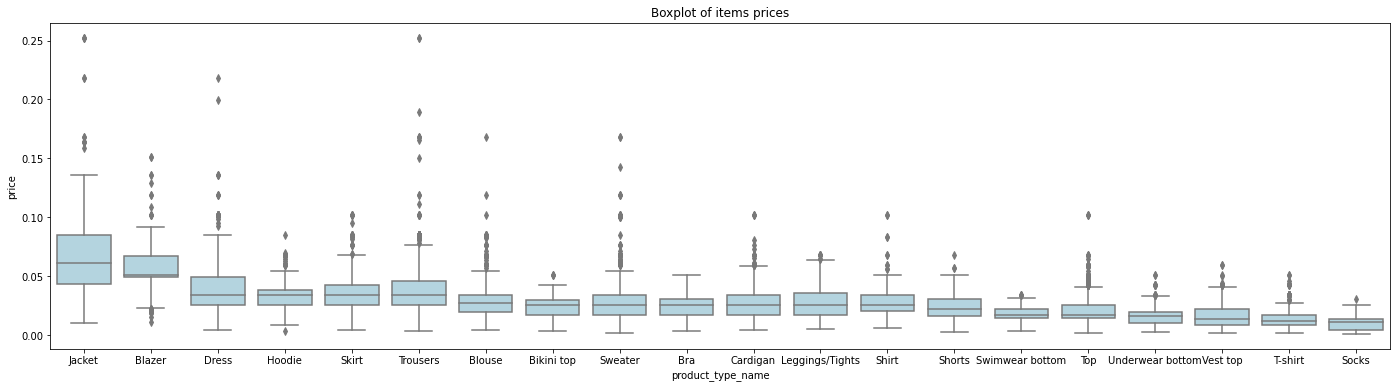

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(24, 6))
_ = list(top_t.groupby('product_type_name')['price'].median().sort_values(ascending=False).index)
sns.boxplot(data=top_t, x='product_type_name', y='price', order=_, color='lightblue')
ax.set(title='Boxplot of items prices');

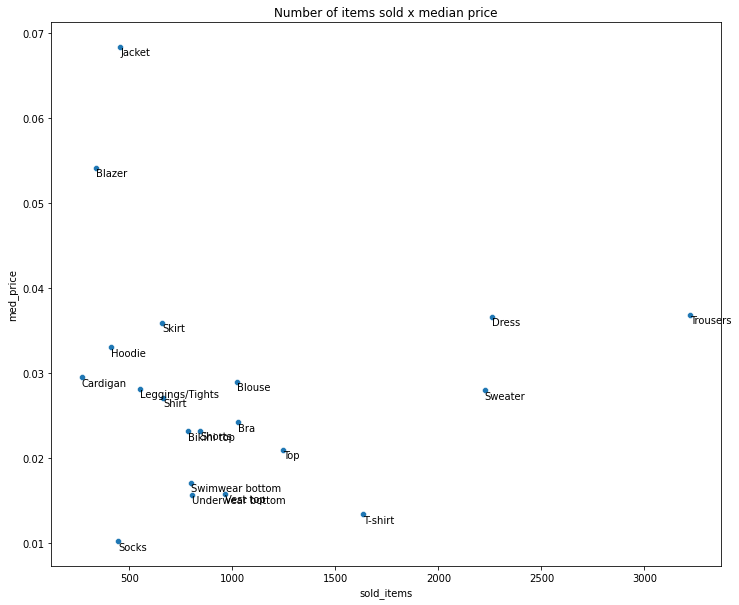

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
_ = top_t.groupby('product_type_name').agg(sold_items=('article_id', 'count'), med_price=('price', 'mean'))

sns.scatterplot(data=_, x='sold_items', y='med_price', ax=ax)

for line in range(0, _.shape[0]):
     ax.text(_.iloc[line]['sold_items']+0.2, _.iloc[line]['med_price']-.001, _.iloc[line].name, horizontalalignment='left', size='medium', color='black')
plt.title('Number of items sold x median price');

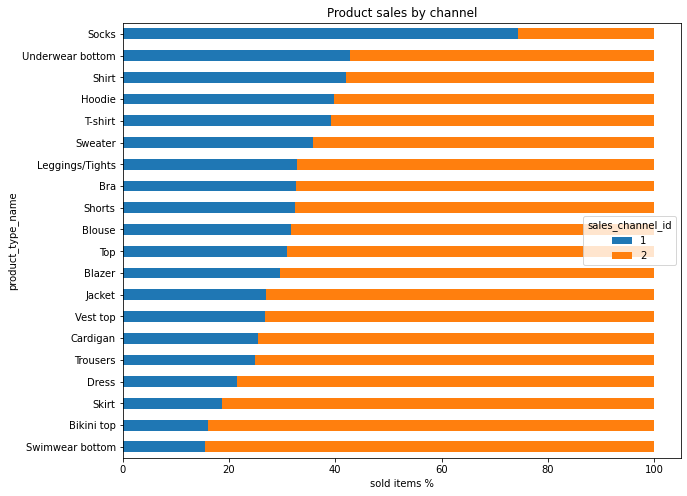

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
(pd.crosstab(
    top_t['product_type_name'],
    top_t['sales_channel_id'],
    top_t['article_id'],
    aggfunc='count',
    normalize='index'
).sort_values(1) * 100).plot.barh(ax=ax, stacked=True)

ax.set(title='Product sales by channel', xlabel='sold items %');

Customers are more likely to buy socks in the brick shop? :D

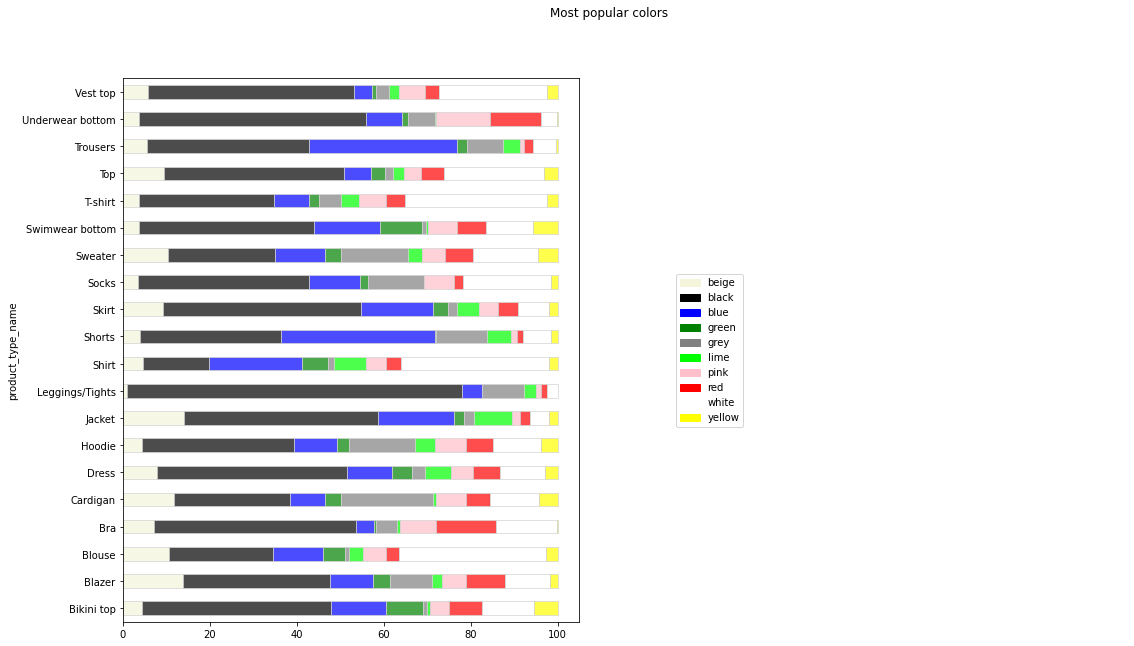

In [96]:
top_colors = (
    top_t['perceived_colour_master_name'].value_counts().sort_values(ascending=False)[:10]
)

top_colors = set(top_colors.index)

_ = top_t[top_t['perceived_colour_master_name'].isin(top_colors)]
ct = pd.crosstab(
    _['product_type_name'],
    _['perceived_colour_master_name'],
    normalize='index'
) * 100

colors = pd.Series(ct.columns).replace({'Khaki green': 'lime'}).str.lower()
fig, ax = plt.subplots(1, 2, figsize=(18, 10))

p = [mpatches.Patch(color=_, label=_) for _ in colors.values]

ax[1].legend(handles=p, loc='center left')
ax[1].axis('off')
ct.plot.barh(stacked=True, color=colors.values, edgecolor='lightgray', legend=False, ax=ax[0], alpha=.7)
fig.suptitle('Most popular colors');

- most of sold leggings / tights are black
- red/pink underwear
- blue trousers and shorts
- top gray item is hoodie/cardigan

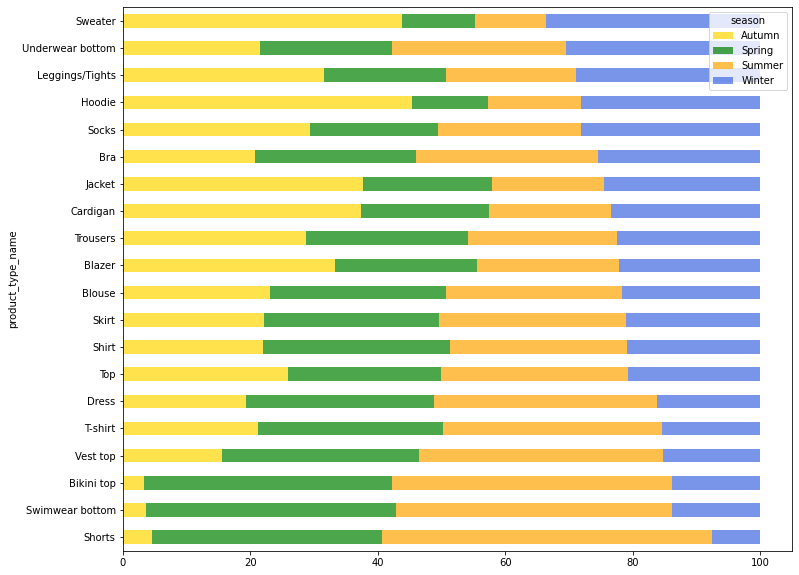

In [104]:
_ = pd.crosstab(top_t['product_type_name'], top_t['season'], normalize='index') * 100
_.sort_values('Winter', ascending=True).plot.barh(figsize=(12, 10), stacked=True, color=['gold', 'green', 'orange', 'royalblue'], alpha=.7);

No surprises here, warm cloths are sold in more cold seasons, and bikini/shorts are sold when it's warm

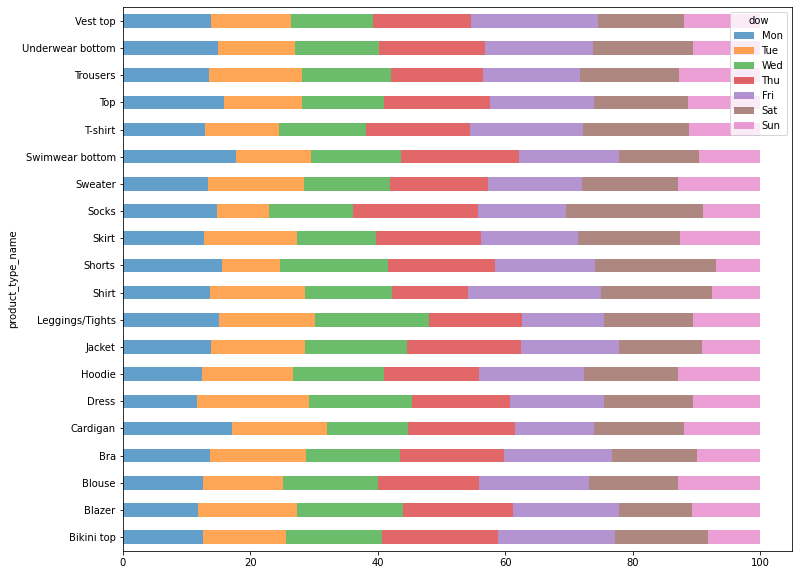

In [292]:
_ = pd.crosstab(top_t['product_type_name'], top_t['dow'], normalize='index') * 100
_[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].plot.barh(stacked=True, figsize=(12, 10), alpha=.7);

<AxesSubplot:>

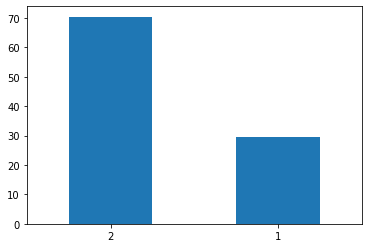

In [4]:
(t_ext['sales_channel_id'].value_counts(normalize=True) * 100).plot.bar(rot=0)

<AxesSubplot:>

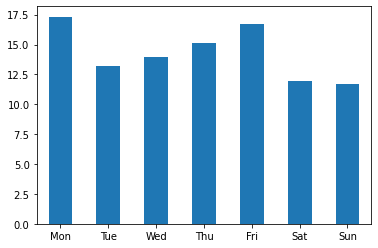

In [60]:
(t_ext['dow'].value_counts(normalize=True) * 100).loc[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].plot.bar(rot=0)

In [46]:
t_ext['perceived_colour_master_name'].value_counts(normalize=True) * 100

Black          41.163
Blue           13.895
White          12.442
Beige           5.872
Grey            5.000
Red             3.895
Pink            3.372
Brown           2.500
Green           2.384
Khaki green     2.151
Yellow          1.686
Orange          1.279
Unknown         1.163
Turquoise       1.105
Mole            1.105
Metal           0.640
Lilac Purple    0.349
Name: perceived_colour_master_name, dtype: float64

In [47]:
t_ext['product_group_name'].value_counts(normalize=True) * 100

Garment Upper body   39.884
Garment Lower body   24.826
Garment Full body    10.407
Underwear             9.593
Swimwear              6.919
Accessories           3.256
Shoes                 2.907
Socks & Tights        1.279
Nightwear             0.640
Unknown               0.233
Bags                  0.058
Name: product_group_name, dtype: float64

In [48]:
t_ext['index_name'].value_counts(normalize=True) * 100

Ladieswear                       42.965
Divided                          25.988
Lingeries/Tights                 15.116
Sport                             5.581
Ladies Accessories                4.593
Menswear                          3.023
Children Sizes 134-170            1.221
Baby Sizes 50-98                  0.756
Children Sizes 92-140             0.698
Children Accessories, Swimwear    0.058
Name: index_name, dtype: float64

In [53]:
t_ext['product_type_name'].value_counts(normalize=True) * 100

Trousers                   15.872
Dress                       9.826
Sweater                     8.430
Top                         6.221
T-shirt                     5.988
Bra                         5.814
Vest top                    5.698
Shorts                      4.360
Bikini top                  3.372
Underwear bottom            3.140
Blouse                      3.140
Jacket                      2.733
Swimwear bottom             2.733
Leggings/Tights             2.616
Hoodie                      2.035
Skirt                       1.919
Shirt                       1.453
Blazer                      1.279
Socks                       0.988
Cardigan                    0.872
Coat                        0.872
Bodysuit                    0.756
Boots                       0.698
Wedge                       0.640
Swimsuit                    0.523
Belt                        0.465
Jumpsuit/Playsuit           0.465
Bag                         0.407
Underwear body              0.407
Sneakers      

In [164]:
# ABC analysis

stats = t_ext.groupby('prod_name').agg(
    total_sum=('price', 'sum'),
    total_count=('price', 'count')
).assign(
    sum_cat = lambda _: pd.qcut(_['total_sum'], [0, .6, .8, 1], labels=['C', 'B', 'A']),
    cnt_cat = lambda _: pd.qcut(_['total_count'], [0, .6, .8, 1], labels=['C', 'B', 'A'])
)

In [188]:
# cohort analysis

full = pd.read_parquet('../data/clean/transactions.parquet')
signups = full.groupby('customer_id').agg(signup_date=('t_dat', 'min'))
cohort = signups[signups['signup_date'].dt.to_period('M') == '2018-09'].sample(n=500).reset_index()
cohort_data = full.merge(cohort, on='customer_id')
del full
cohort_data = cohort_data.merge(items[['article_id', 'prod_name', 'product_group_name', 'perceived_colour_master_name', 'index_name', 'product_type_name']])

stats = cohort_data.groupby('customer_id').agg(
    num_transactions=('t_dat', 'nunique'),
    total_sum=('price', 'sum'),
    prods=('prod_name', 'nunique'),
    colors=('perceived_colour_master_name', 'nunique')
).reset_index().merge(customers, on='customer_id')

age_cat = [17, 27, 35, 50, 100]
stats['age_cat'] = pd.cut(stats['age'], bins=age_cat)

cohort_transactions = cohort_data.groupby(['customer_id', 't_dat']).agg(number_of_items=('price', 'count'), total_sum=('price', 'sum')).reset_index()
cohort_transactions['next'] = cohort_transactions.sort_values('t_dat', ascending=False).groupby('customer_id')['t_dat'].shift()
cohort_transactions['delta'] = cohort_transactions['next'] - cohort_transactions['t_dat']
cohort_transactions['days'] = cohort_transactions['delta'].dt.days

<AxesSubplot:>

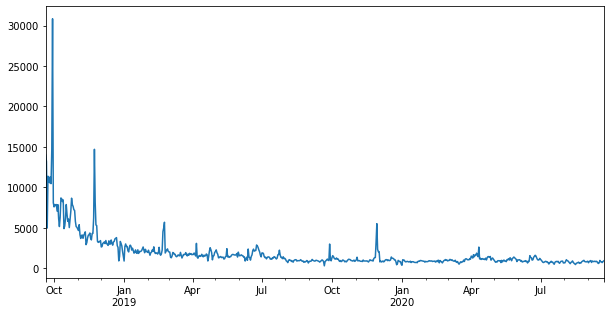

In [180]:
signups['signup_date'].value_counts().sort_index().plot()

<AxesSubplot:>

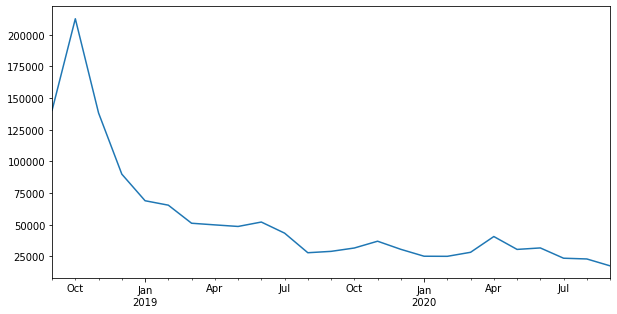

In [183]:
signups['signup_date'].dt.to_period('M').value_counts().sort_index().plot()

<AxesSubplot:xlabel='colors', ylabel='Count'>

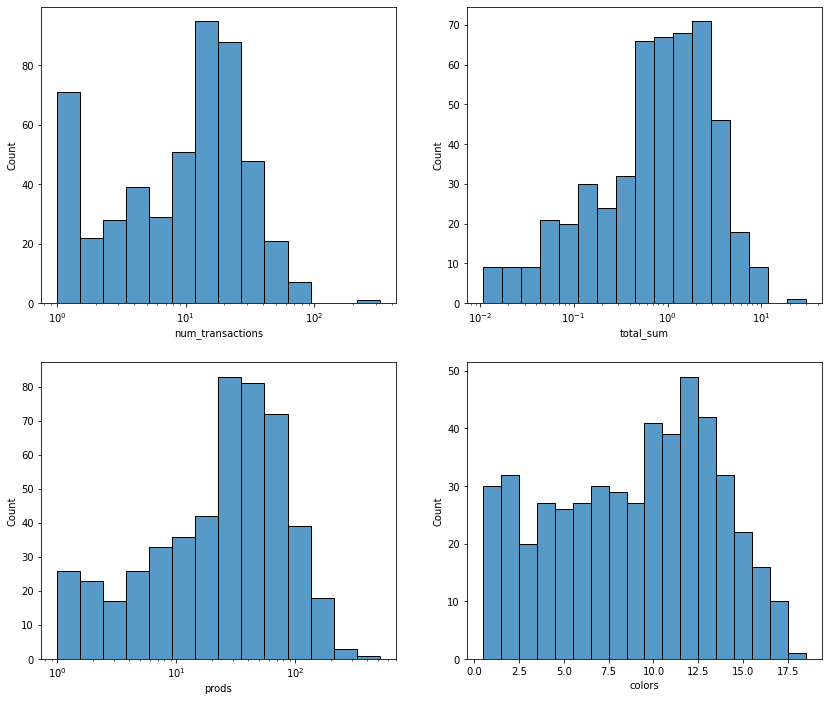

In [220]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
sns.histplot(data=stats, x='num_transactions', log_scale=(True, None), ax=ax[0, 0])
sns.histplot(data=stats, x='total_sum', log_scale=(True, None), ax=ax[0, 1])
sns.histplot(data=stats, x='prods', log_scale=(True, None), ax=ax[1, 0])
sns.histplot(data=stats, x='colors', discrete=True, ax=ax[1, 1])

<AxesSubplot:xlabel='colors', ylabel='Probability'>

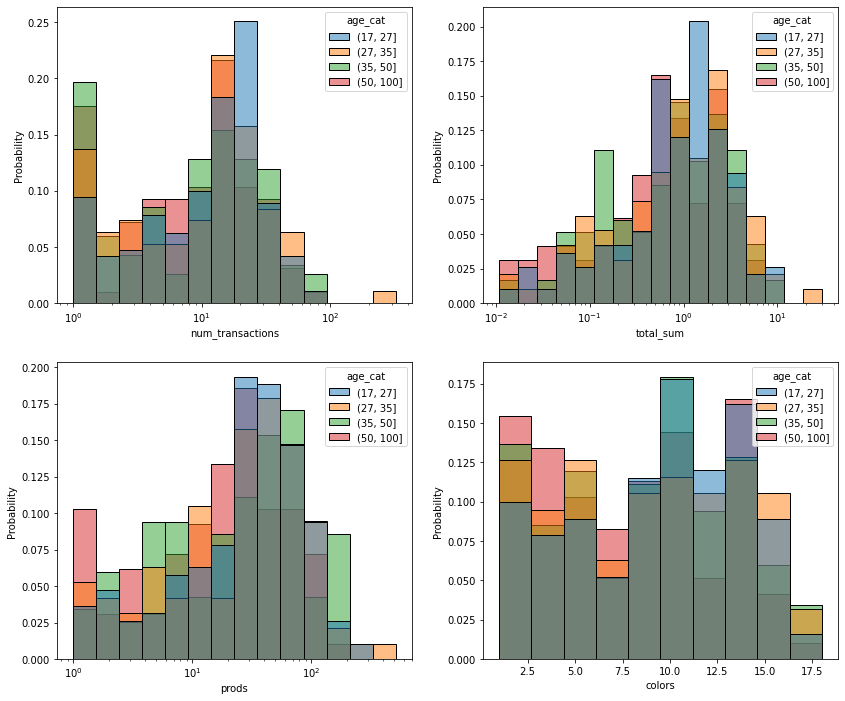

In [284]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
sns.histplot(data=stats, x='num_transactions', log_scale=(True, None), ax=ax[0, 0], hue='age_cat', stat='probability', common_norm=False)
sns.histplot(data=stats, x='total_sum', log_scale=(True, None), ax=ax[0, 1], hue='age_cat', stat='probability', common_norm=False)
sns.histplot(data=stats, x='prods', log_scale=(True, None), ax=ax[1, 0], hue='age_cat', stat='probability', common_norm=False)
sns.histplot(data=stats, x='colors', ax=ax[1, 1], hue='age_cat', stat='probability', common_norm=False)

<AxesSubplot:xlabel='colors', ylabel='Probability'>

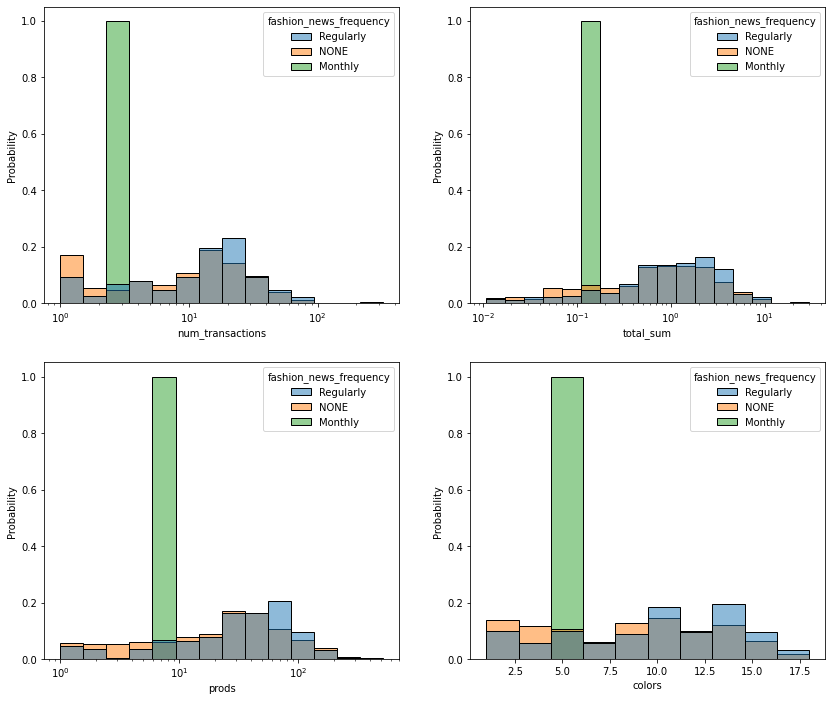

In [285]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
sns.histplot(data=stats, x='num_transactions', log_scale=(True, None), ax=ax[0, 0], hue='fashion_news_frequency', stat='probability', common_norm=False)
sns.histplot(data=stats, x='total_sum', log_scale=(True, None), ax=ax[0, 1], hue='fashion_news_frequency', stat='probability', common_norm=False)
sns.histplot(data=stats, x='prods', log_scale=(True, None), ax=ax[1, 0], hue='fashion_news_frequency', stat='probability', common_norm=False)
sns.histplot(data=stats, x='colors', ax=ax[1, 1], hue='fashion_news_frequency', stat='probability', common_norm=False)

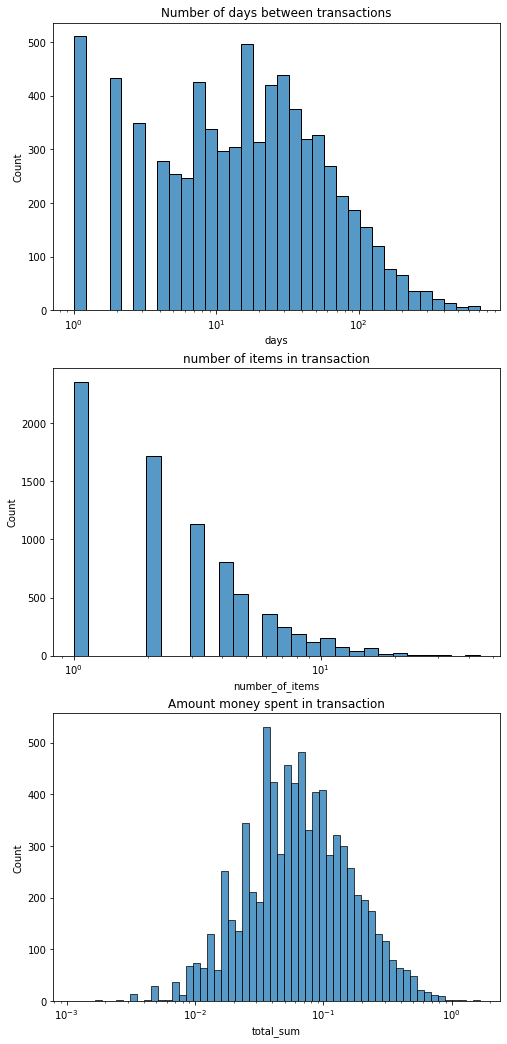

In [288]:
fig, ax = plt.subplots(3, 1, figsize=(8, 18))
sns.histplot(cohort_transactions[cohort_transactions['next'].notna()], x='days', log_scale=(True, None), ax=ax[0])
ax[0].set(title='Number of days between transactions')

sns.histplot(data=cohort_transactions, x='number_of_items', log_scale=(True, None), ax=ax[1])
ax[1].set(title='number of items in transaction')

sns.histplot(data=cohort_transactions, x='total_sum', log_scale=(True, None), ax=ax[2])
ax[2].set(title='Amount money spent in transaction');

In [ ]:
# cosine similarity for some random items
# sparse user x item
# user-id -> row-id
# item-id -> column-id

In [349]:
row_idx = pd.Series(index=t_ext['customer_id'].unique(), data=np.arange(0, t_ext['customer_id'].unique().shape[0]))
col_idx = pd.Series(index=t_ext['article_id'].unique(), data=np.arange(0, t_ext['article_id'].unique().shape[0]))

In [426]:
inv_row_idx = pd.Series(data=t_ext['customer_id'].unique(), index=np.arange(0, t_ext['customer_id'].unique().shape[0]))
inv_col_idx = pd.Series(data=t_ext['article_id'].unique(), index=np.arange(0, t_ext['article_id'].unique().shape[0]))

In [350]:
t_ext['row_id'] = t_ext['customer_id'].map(row_idx)
t_ext['col_id'] = t_ext['article_id'].map(col_idx)

In [391]:
from scipy.sparse import coo_array, linalg

In [461]:
t_ext.groupby('article_id')['customer_id'].nunique().sort_values(ascending=False)[:15]

article_id
372860001    26
706016001    23
759871002    21
399223001    19
610776002    18
464297007    17
568601006    17
608776002    16
564786001    15
372860002    15
706016002    15
673677002    14
673396002    14
706016003    13
599580017    13
Name: customer_id, dtype: int64

In [402]:
X = coo_array(
    (np.ones(t_ext.shape[0]), (t_ext['row_id'], t_ext['col_id'])), dtype=np.int8
).tocsc()

In [ ]:
row_idx.shape[0], col_idx.shape[0]

In [401]:
from sklearn.preprocessing import normalize

In [462]:
col_idx[599580017]

2883

In [416]:
X = normalize(X, axis=0)

In [463]:
v = X[:, [2883]]

In [464]:
_ = v.T.dot(X)
dists = pd.Series(_.toarray()[0])

In [466]:
inv_col_idx[5992]

653664007

In [465]:
dists[dists != 0].sort_values(ascending=False)[:20]

2883    1.000
5992    0.333
11051   0.333
1537    0.333
4548    0.333
2202    0.333
1669    0.269
3752    0.256
9852    0.253
5909    0.252
5993    0.252
1258    0.240
9502    0.240
1255    0.240
1256    0.240
1257    0.240
1259    0.240
11244   0.225
845     0.215
7204    0.201
dtype: float64